In [1]:
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from sklearn.metrics import log_loss, roc_auc_score, f1_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_PATH = 'input/'

In [4]:
BATCH_SIZE = 8192
EPOCHS = 200
LR = 1e-3
WEIGHT_DECAY = 1e-5
EARLYSTOP_NUM = 3
nFOLDS = 5

In [5]:
TRAIN = True
CACHE_PATH ='models/'
print('Reading input data...')
train = pd.read_csv(f'{DATA_PATH}train.csv')
train = train.query('date > 85').reset_index(drop=True)
print('Optimizing memory usage...')
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns})
print('Complete')
features = [c for c in train.columns if 'feature' in c]
f_mean = train[features[1:]].mean()
train[features] = train[features].fillna(method='ffill').fillna(0)
train = train.query('weight > 0').reset_index(drop=True)
train['action'] = (train['resp'] > 0).astype('int') #BCE Target
train['action_1'] = (train['resp_1'] > 0).astype('int')
train['action_2'] = (train['resp_2'] > 0).astype('int')
train['action_3'] = (train['resp_3'] > 0).astype('int')
train['action_4'] = (train['resp_4'] > 0).astype('int')

Reading input data...
Optimizing memory usage...
Complete


In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=42)

In [6]:
def fillna_npwhere_njit(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [7]:
class RunningEWMean:
    def __init__(self, WIN_SIZE=20, n_size=1, lt_mean=None):
        if lt_mean is not None:
            self.s = lt_mean
        else:
            self.s = np.zeros(n_size)
        self.past_value = np.zeros(n_size)
        self.alpha = 2 / (WIN_SIZE + 1)

    def clear(self):
        self.s = 0

    def push(self, x):

        x = fillna_npwhere_njit(x, self.past_value)
        self.past_value = x
        self.s = self.alpha * x + (1 - self.alpha) * self.s

    def get_mean(self):
        return self.s

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score: #  + self.delta
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            # ema.apply_shadow()
            self.save_checkpoint(epoch_score, model, model_path)
            # ema.restore()
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [9]:
target_cols = [target for target in train.columns if 'action' in target]
if TRAIN:
    feat_cols= [col for col in features]
    
    train['cross_41_42_43'] = train['feature_41'] + train['feature_42'] + train['feature_43']
    
    train['cross_1_2'] = train['feature_1'] / (train['feature_2'] + 1e-5)
   
    feat_cols.extend(['cross_41_42_43','cross_1_2'])

In [10]:
len(feat_cols)

132

In [12]:
valid = train.loc[(train.date >= 450) & (train.date < 500)].reset_index(drop=True)
train = train.loc[train.date < 450].reset_index(drop=True)

In [11]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [12]:
class MarketDataset:
    def __init__(self, df):
        self.features = df[feat_cols].values

        self.label = df[target_cols].values.reshape(-1, len(target_cols))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float),
            'label': torch.tensor(self.label[idx], dtype=torch.float)
        }

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d(len(feat_cols))
        self.dropout0 = nn.Dropout(0.2)

        dropout_rate = 0.2
        hidden_size = 256
        self.dense1 = nn.Linear(len(feat_cols), hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense2 = nn.Linear(hidden_size+len(feat_cols), hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.dense5 = nn.Linear(hidden_size+hidden_size, len(target_cols))

        self.Relu = nn.ReLU(inplace=True)
        self.PReLU = nn.PReLU()
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        # self.GeLU = nn.GELU()
        self.RReLU = nn.RReLU()

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.dropout0(x)

        x1 = self.dense1(x)
        x1 = self.batch_norm1(x1)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x1 = self.LeakyReLU(x1)
        x1 = self.dropout1(x1)

        x = torch.cat([x, x1], 1)

        x2 = self.dense2(x)
        x2 = self.batch_norm2(x2)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x2 = self.LeakyReLU(x2)
        x2 = self.dropout2(x2)

        x = torch.cat([x1, x2], 1)

        x3 = self.dense3(x)
        x3 = self.batch_norm3(x3)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x3 = self.LeakyReLU(x3)
        x3 = self.dropout3(x3)

        x = torch.cat([x2, x3], 1)

        x4 = self.dense4(x)
        x4 = self.batch_norm4(x4)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x4 = self.LeakyReLU(x4)
        x4 = self.dropout4(x4)

        x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return x

In [14]:
def train_fn(model, optimizer, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        X,y = data['features'].to(device),data['label'].to(device)
        outputs = model(X)
        loss = loss_fn(outputs,y)
        loss.backward()
        optimizer.step()
        
        final_loss += loss.item()
    final_loss/=len(dataloader)
        
    return final_loss
        

In [15]:
def inference(model, dataloader, device,loss_fn=None):
    model.eval()
    preds = []
    val_loss = 0
    for data in dataloader:
        X,y = data['features'].to(device),data['label'].to(device)
        with torch.no_grad():
            outputs = model(X)
        if loss_fn:
            loss = loss_fn(outputs,y)
        
            val_loss += loss.item()
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
        
        
    preds = np.concatenate(preds).reshape(-1,len(target_cols))
    
    if loss_fn:
        val_loss/=len(dataloader)
    else:
        val_loss = None
    
    
    
    return val_loss, preds

In [16]:
def utility_score_bincount(date, weight, resp, action):
    count_i = len(np.unique(date))
    # print('weight: ', weight)
    # print('resp: ', resp)
    # print('action: ', action)
    # print('weight * resp * action: ', weight * resp * action)
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return u

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [29]:
gkf = PurgedGroupTimeSeriesSplit(n_splits=5, group_gap=20)
splits = list(gkf.split(train[['resp']],groups=train['date'].values))

In [22]:
device = torch.device("cuda")
for _fold in range(nFOLDS):
    print(f'Fold: {_fold}')
    seed_everything(seed=1111+_fold)
    torch.cuda.empty_cache()
    model = Model().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=3,verbose=True)
    
    loss_fn = SmoothBCEwLogits(smoothing=0.005)
    
    model_weights = f'{CACHE_PATH}/online_model_v6_{_fold}.pkl'
    es = EarlyStopping(patience=7,mode='max')
    
    train_set = MarketDataset(train)
    val_set = MarketDataset(valid)
    
    train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=False)
    valid_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
    
    for epoch in (t:=trange(EPOCHS)):
        train_loss = train_fn(model,optimizer,loss_fn,train_loader,device)
        
        valid_loss, valid_preds = inference(model,valid_loader,device,loss_fn)
        
        roc_score = roc_auc_score(valid[target_cols].values,valid_preds)
        valid_preds = np.median(valid_preds,axis=1)
        valid_preds = np.where(valid_preds >= 0.5, 1, 0).astype(int)
        f1 = f1_score(valid[['action']].values,valid_preds)
        scheduler.step(f1)
        valid_u_score = utility_score_bincount(date=valid.date.values,weight=valid.weight.values,
                                               resp=valid.resp.values,action=valid_preds)
        nn.utils.clip_grad_norm_(model.parameters(),5)
        
        es(f1,model,model_path=model_weights)
        if es.early_stop:
            print('Early stopping')
            break
        
        t.set_description("Train loss {} Valid loss {} ROC_score {} f1_score {} Utility_score {}".format(train_loss,valid_loss,roc_score,f1,valid_u_score))
    

Fold: 0


Train loss 0.6942214053578493 Valid loss 0.6899000365158607 ROC_score 0.5406128243802982 f1_score 0.49847951979268584 Utility_score 862.7976144912805:   0%|          | 1/200 [00:40<2:14:36, 40.59s/it]

Validation score improved (-inf --> 0.49847951979268584). Saving model!


Train loss 0.6910398864164585 Valid loss 0.6891503313492084 ROC_score 0.5450345295385846 f1_score 0.4910939077751599 Utility_score 1093.113411911562:   1%|          | 2/200 [01:20<2:12:46, 40.24s/it] 

EarlyStopping counter: 1 out of 7


Train loss 0.6904450676790098 Valid loss 0.6889645148967874 ROC_score 0.5458816805894727 f1_score 0.5084474518484372 Utility_score 1384.524902778681:   2%|▏         | 3/200 [02:00<2:12:39, 40.40s/it]

Validation score improved (0.49847951979268584 --> 0.5084474518484372). Saving model!


Train loss 0.6900495025442868 Valid loss 0.6887563734218992 ROC_score 0.5462245560410363 f1_score 0.5370017654022128 Utility_score 1414.6836732567908:   2%|▏         | 4/200 [02:41<2:12:01, 40.42s/it]

Validation score improved (0.5084474518484372 --> 0.5370017654022128). Saving model!


Train loss 0.6898129920407039 Valid loss 0.6888869569219392 ROC_score 0.5454548256923072 f1_score 0.5605082193694604 Utility_score 1451.50843683913:   2%|▎         | 5/200 [03:22<2:12:14, 40.69s/it]  

Validation score improved (0.5370017654022128 --> 0.5605082193694604). Saving model!


Train loss 0.6896006239623558 Valid loss 0.688597296846324 ROC_score 0.5472304048090204 f1_score 0.5677851065863684 Utility_score 1492.4527852091264:   3%|▎         | 6/200 [04:00<2:09:21, 40.01s/it]

Validation score improved (0.5605082193694604 --> 0.5677851065863684). Saving model!


Train loss 0.689417319690309 Valid loss 0.6884307943541428 ROC_score 0.5477792335105058 f1_score 0.5742506478900787 Utility_score 1510.8063647084298:   4%|▎         | 7/200 [04:40<2:08:28, 39.94s/it]

Validation score improved (0.5677851065863684 --> 0.5742506478900787). Saving model!


Train loss 0.6892828792333603 Valid loss 0.6883258799026752 ROC_score 0.548769472614652 f1_score 0.5534497571095442 Utility_score 1589.8587171756867:   4%|▍         | 8/200 [05:21<2:08:43, 40.22s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6890800035581356 Valid loss 0.6882167253000983 ROC_score 0.5492379396677609 f1_score 0.5211215462325053 Utility_score 1521.4480885246426:   4%|▍         | 9/200 [06:03<2:09:10, 40.58s/it]

EarlyStopping counter: 2 out of 7


Train loss 0.6890088221648845 Valid loss 0.6881525701489942 ROC_score 0.5497461577133531 f1_score 0.5084495731568933 Utility_score 1488.6716003559818:   5%|▌         | 10/200 [06:44<2:09:14, 40.81s/it]

EarlyStopping counter: 3 out of 7


Train loss 0.6888465626937587 Valid loss 0.6880754109086662 ROC_score 0.5500923809655516 f1_score 0.5091581642668016 Utility_score 1545.482611927263:   6%|▌         | 11/200 [07:26<2:09:19, 41.06s/it] 

Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 7


Train loss 0.6880431327877975 Valid loss 0.6875145065373388 ROC_score 0.552555440074226 f1_score 0.5508385534051444 Utility_score 1938.2076562199377:   6%|▌         | 12/200 [08:07<2:09:08, 41.22s/it]

EarlyStopping counter: 5 out of 7


Train loss 0.687688393927202 Valid loss 0.6874578821248022 ROC_score 0.5528473653088715 f1_score 0.5482939515949907 Utility_score 1979.2596690431096:   6%|▋         | 13/200 [08:50<2:09:32, 41.56s/it]

EarlyStopping counter: 6 out of 7


Train loss 0.687688393927202 Valid loss 0.6874578821248022 ROC_score 0.5528473653088715 f1_score 0.5482939515949907 Utility_score 1979.2596690431096:   6%|▋         | 13/200 [09:31<2:17:06, 43.99s/it]

EarlyStopping counter: 7 out of 7
Early stopping
Fold: 1



Train loss 0.694222438989616 Valid loss 0.689551869343067 ROC_score 0.5419043347498517 f1_score 0.5501508101847277 Utility_score 1136.3073665192555:   0%|          | 1/200 [00:41<2:18:55, 41.89s/it]

Validation score improved (-inf --> 0.5501508101847277). Saving model!


Train loss 0.6911067711870845 Valid loss 0.6889642867548712 ROC_score 0.5458634619345621 f1_score 0.5072906867356538 Utility_score 1162.7675288115072:   1%|          | 2/200 [01:23<2:17:32, 41.68s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6904247624845039 Valid loss 0.6887483267948545 ROC_score 0.5466059296971306 f1_score 0.5274590163934426 Utility_score 1422.872358467016:   2%|▏         | 3/200 [02:05<2:17:20, 41.83s/it] 

EarlyStopping counter: 2 out of 7


Train loss 0.69001575722927 Valid loss 0.6886494426891722 ROC_score 0.5470380542551727 f1_score 0.5437901109989909 Utility_score 1458.5460215938137:   2%|▏         | 4/200 [02:47<2:17:00, 41.94s/it] 

EarlyStopping counter: 3 out of 7


Train loss 0.6897813238021804 Valid loss 0.6886787620084039 ROC_score 0.5469331211848643 f1_score 0.5658792086507741 Utility_score 1453.975271158827:   2%|▎         | 5/200 [03:30<2:16:59, 42.15s/it]

Validation score improved (0.5501508101847277 --> 0.5658792086507741). Saving model!


Train loss 0.689595004043928 Valid loss 0.6886385514818388 ROC_score 0.5469105544647295 f1_score 0.5646481682569754 Utility_score 1588.4240536590883:   3%|▎         | 6/200 [04:12<2:16:58, 42.36s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6894044018373257 Valid loss 0.6883797337268961 ROC_score 0.5483070244312009 f1_score 0.5635005253723963 Utility_score 1662.0596834404764:   4%|▎         | 7/200 [04:54<2:15:57, 42.26s/it]

EarlyStopping counter: 2 out of 7


Train loss 0.6892577791359367 Valid loss 0.6883892766360579 ROC_score 0.5485875744893103 f1_score 0.5552850756927157 Utility_score 1580.1233088772856:   4%|▍         | 8/200 [05:36<2:14:16, 41.96s/it]

EarlyStopping counter: 3 out of 7


Train loss 0.6891325813968007 Valid loss 0.6879937607666542 ROC_score 0.5504640589494673 f1_score 0.5316444096403609 Utility_score 1588.5277117873818:   4%|▍         | 9/200 [06:13<2:08:53, 40.49s/it]

Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 7


Train loss 0.6882676772954988 Valid loss 0.6874791650936521 ROC_score 0.5530425285611595 f1_score 0.5407204353142978 Utility_score 1933.39065200274:   5%|▌         | 10/200 [06:50<2:05:31, 39.64s/it] 

EarlyStopping counter: 5 out of 7


Train loss 0.688052435473698 Valid loss 0.6874526595247203 ROC_score 0.5532159942482491 f1_score 0.5364313424475655 Utility_score 1995.9452751354534:   6%|▌         | 11/200 [07:28<2:03:16, 39.13s/it]

EarlyStopping counter: 6 out of 7


Train loss 0.688052435473698 Valid loss 0.6874526595247203 ROC_score 0.5532159942482491 f1_score 0.5364313424475655 Utility_score 1995.9452751354534:   6%|▌         | 11/200 [08:06<2:19:16, 44.22s/it]

EarlyStopping counter: 7 out of 7
Early stopping
Fold: 2



Train loss 0.6943906356648701 Valid loss 0.6898654432132326 ROC_score 0.541190879354628 f1_score 0.5182802734499475 Utility_score 1299.588033196664:   0%|          | 1/200 [00:38<2:06:31, 38.15s/it]

Validation score improved (-inf --> 0.5182802734499475). Saving model!


Train loss 0.6911887806363222 Valid loss 0.6889548178376823 ROC_score 0.545656713769208 f1_score 0.500902757594173 Utility_score 1330.9403709622125:   1%|          | 2/200 [01:15<2:05:24, 38.00s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.69044313488937 Valid loss 0.6887619927011687 ROC_score 0.546242573562458 f1_score 0.5236928310975251 Utility_score 1237.351447075281:   2%|▏         | 3/200 [01:54<2:05:05, 38.10s/it]  

Validation score improved (0.5182802734499475 --> 0.5236928310975251). Saving model!


Train loss 0.6901187213455758 Valid loss 0.6886296292831158 ROC_score 0.5470000646709117 f1_score 0.5382173541800295 Utility_score 1444.982908130064:   2%|▏         | 4/200 [02:33<2:05:21, 38.37s/it]

Validation score improved (0.5236928310975251 --> 0.5382173541800295). Saving model!


Train loss 0.6897432636923906 Valid loss 0.6887641734090345 ROC_score 0.5461131207807627 f1_score 0.5716231194368051 Utility_score 1453.0149817439105:   2%|▎         | 5/200 [03:10<2:03:37, 38.04s/it]

Validation score improved (0.5382173541800295 --> 0.5716231194368051). Saving model!


Train loss 0.6896495419304546 Valid loss 0.6885464458630003 ROC_score 0.5475495952640894 f1_score 0.5703125594273675 Utility_score 1552.108827768:   3%|▎         | 6/200 [03:48<2:03:17, 38.13s/it]    

EarlyStopping counter: 1 out of 7


Train loss 0.6894541484553639 Valid loss 0.688333887478401 ROC_score 0.5483980590255999 f1_score 0.5629199862118649 Utility_score 1479.6487659440722:   4%|▎         | 7/200 [04:28<2:04:29, 38.70s/it]

EarlyStopping counter: 2 out of 7


Train loss 0.6893038553435628 Valid loss 0.6881955224892189 ROC_score 0.5492345532412317 f1_score 0.5475336484972145 Utility_score 1477.1597595996063:   4%|▍         | 8/200 [05:06<2:03:02, 38.45s/it]

EarlyStopping counter: 3 out of 7


Train loss 0.6891266489174308 Valid loss 0.6882861133279472 ROC_score 0.5489835837480805 f1_score 0.5156377715637772 Utility_score 1492.7978804062977:   4%|▍         | 9/200 [05:47<2:04:54, 39.24s/it]

Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 7


Train loss 0.6883789264574284 Valid loss 0.687670306912784 ROC_score 0.5519060789279354 f1_score 0.5360686422288846 Utility_score 1905.061235102301:   5%|▌         | 10/200 [06:26<2:03:44, 39.07s/it] 

EarlyStopping counter: 5 out of 7


Train loss 0.6880551027815517 Valid loss 0.6876125726206549 ROC_score 0.5522542393435816 f1_score 0.5357228671091115 Utility_score 1864.1387001226553:   6%|▌         | 11/200 [07:04<2:02:32, 38.90s/it]

EarlyStopping counter: 6 out of 7


Train loss 0.6880551027815517 Valid loss 0.6876125726206549 ROC_score 0.5522542393435816 f1_score 0.5357228671091115 Utility_score 1864.1387001226553:   6%|▌         | 11/200 [07:41<2:12:15, 41.98s/it]

EarlyStopping counter: 7 out of 7
Early stopping
Fold: 3



Train loss 0.6943177304616789 Valid loss 0.6896747864525894 ROC_score 0.54086496073723 f1_score 0.5211111997950003 Utility_score 977.3179389108732:   0%|          | 1/200 [00:38<2:07:00, 38.29s/it]

Validation score improved (-inf --> 0.5211111997950003). Saving model!


Train loss 0.6911503316425696 Valid loss 0.6890310295696916 ROC_score 0.544764364133137 f1_score 0.5108992060752503 Utility_score 1222.2763160884142:   1%|          | 2/200 [01:16<2:06:26, 38.32s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6904660586903735 Valid loss 0.6888415094079643 ROC_score 0.5456740506856306 f1_score 0.5386382895508767 Utility_score 1368.4691665149105:   2%|▏         | 3/200 [01:53<2:04:03, 37.79s/it]

Validation score improved (0.5211111997950003 --> 0.5386382895508767). Saving model!


Train loss 0.6901644820847163 Valid loss 0.6888160212286587 ROC_score 0.5455029806625389 f1_score 0.5603974615250257 Utility_score 1348.6572317105301:   2%|▏         | 4/200 [02:30<2:03:00, 37.65s/it]

Validation score improved (0.5386382895508767 --> 0.5603974615250257). Saving model!


Train loss 0.6898620321256358 Valid loss 0.6887718459655499 ROC_score 0.5460074636564927 f1_score 0.5757988679584318 Utility_score 1455.6254751857875:   2%|▎         | 5/200 [03:08<2:02:19, 37.64s/it]

Validation score improved (0.5603974615250257 --> 0.5757988679584318). Saving model!


Train loss 0.6896507376577796 Valid loss 0.6887145165739388 ROC_score 0.5470650815296473 f1_score 0.5758684619562165 Utility_score 1437.0784723579814:   3%|▎         | 6/200 [03:45<2:01:13, 37.49s/it]

Validation score improved (0.5757988679584318 --> 0.5758684619562165). Saving model!


Train loss 0.6895104196013474 Valid loss 0.6883740938943008 ROC_score 0.5485102730174797 f1_score 0.5607733623110508 Utility_score 1618.7189283925134:   4%|▎         | 7/200 [04:24<2:02:16, 38.01s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.689345764677699 Valid loss 0.6883306852702437 ROC_score 0.5487349295268437 f1_score 0.5320415557711282 Utility_score 1506.7095789743753:   4%|▍         | 8/200 [05:03<2:02:23, 38.25s/it] 

EarlyStopping counter: 2 out of 7


Train loss 0.6891914348049861 Valid loss 0.688182284092081 ROC_score 0.5498390475975724 f1_score 0.5084505996847672 Utility_score 1628.036824528428:   4%|▍         | 9/200 [05:40<2:00:41, 37.91s/it] 

EarlyStopping counter: 3 out of 7


Train loss 0.688936677284357 Valid loss 0.6881314659940785 ROC_score 0.550124486626079 f1_score 0.5072042068361087 Utility_score 1530.010572511973:   5%|▌         | 10/200 [06:19<2:00:49, 38.15s/it]

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 7


Train loss 0.6882175566946588 Valid loss 0.687492296613496 ROC_score 0.5529379230246932 f1_score 0.5457901911779024 Utility_score 1937.0453762058125:   6%|▌         | 11/200 [06:57<2:00:18, 38.19s/it]

EarlyStopping counter: 5 out of 7


Train loss 0.6878543125420082 Valid loss 0.6874830620042209 ROC_score 0.5531221563299108 f1_score 0.5419132513158003 Utility_score 2042.8376131268708:   6%|▌         | 12/200 [07:35<1:59:55, 38.27s/it]

EarlyStopping counter: 6 out of 7


Train loss 0.6878543125420082 Valid loss 0.6874830620042209 ROC_score 0.5531221563299108 f1_score 0.5419132513158003 Utility_score 2042.8376131268708:   6%|▌         | 12/200 [08:15<2:09:15, 41.25s/it]

EarlyStopping counter: 7 out of 7
Early stopping
Fold: 4



Train loss 0.6939800621532812 Valid loss 0.6894721142176924 ROC_score 0.5417868612877221 f1_score 0.5326166083333677 Utility_score 1063.9256372547484:   0%|          | 1/200 [00:39<2:10:00, 39.20s/it]

Validation score improved (-inf --> 0.5326166083333677). Saving model!


Train loss 0.6910778433084488 Valid loss 0.6893048142564708 ROC_score 0.5437460089126365 f1_score 0.5029602135034816 Utility_score 1122.8546488364586:   1%|          | 2/200 [01:16<2:07:18, 38.58s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6903264864188868 Valid loss 0.6889166133157139 ROC_score 0.5453324322886843 f1_score 0.527347354619968 Utility_score 1291.0982369901353:   2%|▏         | 3/200 [01:54<2:06:29, 38.52s/it] 

EarlyStopping counter: 2 out of 7


Train loss 0.6900058595872507 Valid loss 0.6889884389680008 ROC_score 0.5453040743915294 f1_score 0.5512522152137111 Utility_score 1307.7812400844446:   2%|▏         | 4/200 [02:34<2:07:04, 38.90s/it]

Validation score improved (0.5326166083333677 --> 0.5512522152137111). Saving model!


Train loss 0.6897625421605459 Valid loss 0.6889858266402935 ROC_score 0.5456751870938453 f1_score 0.5708157759117227 Utility_score 1510.799623723227:   2%|▎         | 5/200 [03:14<2:07:45, 39.31s/it] 

Validation score improved (0.5512522152137111 --> 0.5708157759117227). Saving model!


Train loss 0.6896182814749275 Valid loss 0.6887458398424345 ROC_score 0.5466530316189202 f1_score 0.5762994852597099 Utility_score 1497.759544310115:   3%|▎         | 6/200 [03:53<2:06:31, 39.13s/it]

Validation score improved (0.5708157759117227 --> 0.5762994852597099). Saving model!


Train loss 0.6894278987878706 Valid loss 0.6884313698472648 ROC_score 0.5480524650397581 f1_score 0.5506698250293609 Utility_score 1598.0341521730227:   4%|▎         | 7/200 [04:31<2:05:04, 38.89s/it]

EarlyStopping counter: 1 out of 7


Train loss 0.6892556933368125 Valid loss 0.6882723569869995 ROC_score 0.5489411347252175 f1_score 0.5256401076568626 Utility_score 1516.732406236661:   4%|▍         | 8/200 [05:11<2:04:59, 39.06s/it] 

EarlyStopping counter: 2 out of 7


Train loss 0.6890666786490417 Valid loss 0.6881341687564192 ROC_score 0.5496490332942653 f1_score 0.522676794221868 Utility_score 1612.6142193528842:   4%|▍         | 9/200 [05:50<2:04:51, 39.22s/it]

EarlyStopping counter: 3 out of 7


Train loss 0.6889106347793486 Valid loss 0.6882343497769586 ROC_score 0.5497333597614448 f1_score 0.5122866953385127 Utility_score 1572.6847496620373:   5%|▌         | 10/200 [06:29<2:03:56, 39.14s/it]

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 7


Train loss 0.6882405677219716 Valid loss 0.6875546882892477 ROC_score 0.5527519811411565 f1_score 0.5488500193274063 Utility_score 1934.5000803592748:   6%|▌         | 11/200 [07:09<2:03:45, 39.29s/it]

EarlyStopping counter: 5 out of 7


Train loss 0.6878732188445765 Valid loss 0.687488814880108 ROC_score 0.5531700952104107 f1_score 0.5457136361421914 Utility_score 2021.3236089506315:   6%|▌         | 12/200 [07:49<2:03:23, 39.38s/it] 

EarlyStopping counter: 6 out of 7


Train loss 0.6878732188445765 Valid loss 0.687488814880108 ROC_score 0.5531700952104107 f1_score 0.5457136361421914 Utility_score 2021.3236089506315:   6%|▌         | 12/200 [08:27<2:12:28, 42.28s/it]

EarlyStopping counter: 7 out of 7
Early stopping


In [17]:
test_set = train.query('date > 400').reset_index(drop=True)

In [18]:
models = {}
metrics = {}
y_hat = {}
for mFold in range(nFOLDS):
    device = torch.device("cuda")
    resnet = Model().to(device)
    resnet.load_state_dict(torch.load('models/online_model_v6_{}.pkl'.format(mFold)))
    resnet.eval()
    model_name = f"M_{mFold}"
    models[model_name] = resnet
    
    val_set = MarketDataset(test_set)
    val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
    
    valid_preds = []
    _, valid_preds = inference(resnet,val_loader,device)

    
    
    roc_score = roc_auc_score(test_set[target_cols].values,valid_preds)
    valid_preds = np.median(valid_preds,axis=1)
    valid_preds = np.where(valid_preds >= 0.503, 1, 0).astype(int)
    f1 = f1_score(test_set[['action']].values,valid_preds)
    valid_u_score = utility_score_bincount(date=test_set.date.values,weight=test_set.weight.values,
                                            resp=test_set.resp.values,action=valid_preds)
    y_hat[model_name] = valid_preds
    
    metrics[model_name] = {
        "f1":f1,
        "AUC":roc_score,
        "utility": valid_u_score
    }
metrics = pd.DataFrame(metrics).T.astype(float)

Text(0, 0.5, '')

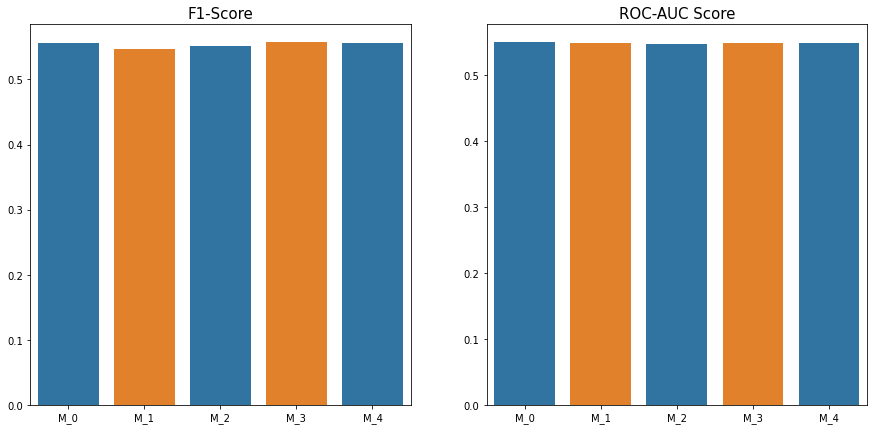

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(15,7))
sns.barplot(x=metrics.index,y='f1', data=metrics,palette=["#1f77b4","#ff7f0e"],ax=ax[0])
sns.barplot(x=metrics.index,y='AUC', data=metrics,palette=["#1f77b4","#ff7f0e"],ax=ax[1])

ax[0].set_title("F1-Score",fontsize=15)
ax[1].set_title("ROC-AUC Score",fontsize=15)

ax[0].set_ylabel("",visible=False)
ax[1].set_ylabel("",visible=False)

In [20]:
def ensemble_selector(loss_function, y_hats, y_true, init_size=1,
                      replacement=True, max_iter=100,binary_proba=True):
    """Implementation of the algorithm of Caruana et al. (2004) 'Ensemble
    Selection from Libraries of Models'. Given a loss function mapping
    predicted and ground truth values to a scalar along with a dictionary of
    models with predicted and ground truth values, constructs an optimal
    ensemble minimizing ensemble loss, by default allowing models to appear
    several times in the ensemble.

    Parameters
    ----------
    loss_function: function
        accepting two arguments - numpy arrays of predictions and true values - 
        and returning a scalar
    y_hats: dict
        with keys being model names and values being numpy arrays of predicted
        values
    y_true: np.array
        numpy array of true values, same for each model
    init_size: int
        number of models in the initial ensemble, picked by the best loss.
        Default is 1
    replacement: bool
        whether the models should be returned back to the pool of models once
        added to the ensemble. Default is True
    max_iter: int
        number of iterations for selection with replacement to perform. Only
        relevant if 'replacement' is True, otherwise iterations continue until
        the dataset is exhausted i.e.
        min(len(y_hats.keys())-init_size, max_iter). Default is 100

    Returns
    -------
    ensemble_loss: pd.Series
        with loss of the ensemble over iterations
    model_weights: pd.DataFrame
        with model names across columns and ensemble selection iterations
        across rows. Each value is the weight of a model in the ensemble

    """
    # Step 1: compute losses
    losses = dict()
    for model, y_hat in y_hats.items():
        if binary_proba:
            
            valid_pred = np.where(y_hat >= 0.5, 1, 0).astype(int)
            losses[model] = loss_function(y_true,valid_pred)
        else:
            losses[model] = loss_function(y_true,valid_pred)

    # Get the initial ensemble comprised of the best models
    losses = pd.Series(losses).sort_values()
    init_ensemble = losses.iloc[:init_size].index.tolist()

    # Compute its loss
    if init_size == 1:
        # Take the best loss
        init_loss = losses.loc[init_ensemble].values[0]
        y_hat_avg = y_hats[init_ensemble[0]].copy()
    else:
        # Average the predictions over several models
        y_hat_avg = np.array(
            [y_hats[mod] for mod in init_ensemble]).mean(axis=0)
        if binary_proba:
            valid_pred_avg = np.where(y_hat_avg >= 0.5, 1, 0).astype(int)
            init_loss = loss_function(y_true,valid_pred_avg)
        else:
            init_loss = loss_function(y_true,y_hat_avg)

    # Define the set of available models
    if replacement:
        available_models = list(y_hats.keys())
    else:
        available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
        max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
    current_loss = init_loss
    current_size = init_size

    loss_progress = [current_loss]
    ensemble_members = [init_ensemble]
    for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            if binary_proba:
                
                tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
                valid_tmp_avg = np.where(tmp_y_avg[mod] >= 0.5, 1, 0).astype(int)
                tmp_losses[mod] = loss_function(y_true,valid_tmp_avg)
            else:
                tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
                tmp_losses[mod] = loss_function(y_true,tmp_y_avg[mod])

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

        if not replacement:
            available_models.remove(best_model)

    # Organize the output
    ensemble_loss = pd.Series(loss_progress, name="loss")
    model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())
    for ix, row in model_weights.iterrows():
        weights = pd.Series(ensemble_members[ix]).value_counts()
        weights = weights / weights.sum()
        model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)

In [21]:
ensemble_loss, model_weights = ensemble_selector(
    loss_function=lambda p,t:-f1_score(p,t), y_hats=y_hat,
    y_true=test_set[['action']].values,init_size=1,replacement=True,max_iter=10
)
# ensemble_AUC, model_weights_AUC = ensemble_selector(
#     loss_function=lambda p,t:-roc_auc_score(p,t), y_hats=y_hat,
#     y_true=test_set[['action']].values,init_size=1,replacement=True,max_iter=10
# )

In [22]:
y_val_avg = np.array([_y for m, _y in y_hat.items()]).mean(axis=0)
y_val_avg = np.where(y_val_avg >= 0.5, 1, 0).astype(int)
ens_loss_val_avg = f1_score(y_val_avg,test_set[['action']].values)
ens_utility_avg =  utility_score_bincount(date=test_set.date.values,weight=test_set.weight.values,
                                        resp=test_set.resp.values,action=y_val_avg)

In [23]:
print(-ensemble_loss)

0     0.556781
1     0.569546
2     0.557267
3     0.564495
4     0.557267
5     0.564495
6     0.557267
7     0.564495
8     0.557267
9     0.564495
10    0.557267
Name: loss, dtype: float64


In [45]:
print(-ensemble_AUC)

0     0.522155
1     0.522155
2     0.522155
3     0.522155
4     0.522155
5     0.522155
6     0.522155
7     0.522155
8     0.522155
9     0.522155
10    0.522155
Name: loss, dtype: float64


In [24]:
model_weights

,M_0,M_1,M_2,M_3,M_4
0,0.000000,0.0,0.0,1.000000,0.000000
1,0.500000,0.0,0.0,0.500000,0.000000
2,0.333333,0.0,0.0,0.333333,0.333333
3,0.250000,0.0,0.0,0.500000,0.250000
4,0.400000,0.0,0.0,0.400000,0.200000
5,0.333333,0.0,0.0,0.500000,0.166667
6,0.428571,0.0,0.0,0.428571,0.142857
7,0.375000,0.0,0.0,0.500000,0.125000
8,0.444444,0.0,0.0,0.444444,0.111111
9,0.400000,0.0,0.0,0.500000,0.100000


In [25]:
ensemble_f1_test = []
U_score = []
for _, row in model_weights.iterrows():
    tmp_y_hat = np.array(
        [y_hat[model_name]*weight for model_name, weight in row.items()]
        ).sum(axis=0)
    tmp_y_hat = np.where(tmp_y_hat>=0.5, 1, 0).astype(int)
    ensemble_f1_test.append(f1_score(tmp_y_hat, test_set[['action']].values))
    U_score.append(utility_score_bincount(date=test_set.date.values,weight=test_set.weight.values,
                                        resp=test_set.resp.values,action=tmp_y_hat))
ensemble_f1_test = pd.Series(ensemble_f1_test)
U_score = pd.Series(U_score)

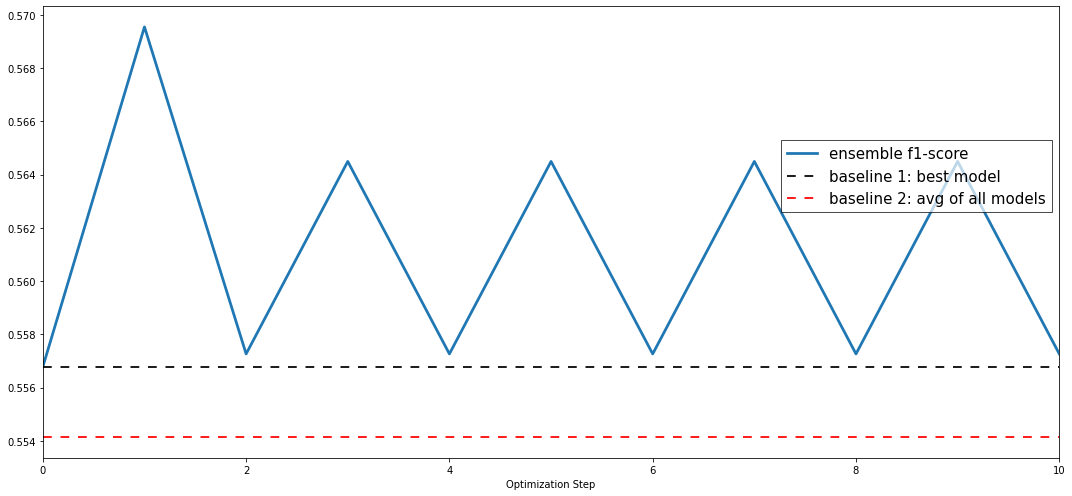

In [26]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(ensemble_f1_test,color="#1f77b4",lw=2.75,label='ensemble f1-score')
ax.plot(pd.Series(ensemble_f1_test[0],ensemble_f1_test.index),color='k',lw=1.75,ls='--',dashes=(5,5),label='baseline 1: best model')
ax.plot(pd.Series(ens_loss_val_avg,ensemble_loss.index),color='r',lw=1.75,ls='--',dashes=(5,5),label='baseline 2: avg of all models')

ax.margins(x=0.0)
ax.set_xlabel('Optimization Step',visible=True)
ax.legend(loc="upper right", bbox_to_anchor=(1, 0.72),
                 frameon=True, edgecolor="k", fancybox=False,
                 framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()

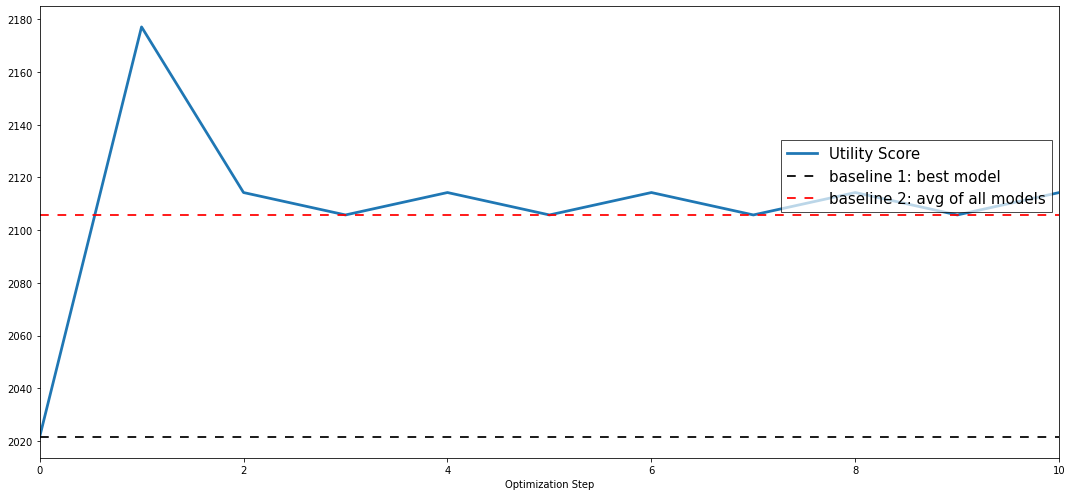

In [27]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(U_score,color="#1f77b4",lw=2.75,label='Utility Score')
ax.plot(pd.Series(U_score[0],U_score.index),color='k',lw=1.75,ls='--',dashes=(5,5),label='baseline 1: best model')
ax.plot(pd.Series(ens_utility_avg,ensemble_loss.index),color='r',lw=1.75,ls='--',dashes=(5,5),label='baseline 2: avg of all models')

ax.margins(x=0.0)
ax.set_xlabel('Optimization Step',visible=True)
ax.legend(loc="upper right", bbox_to_anchor=(1, 0.72),
                 frameon=True, edgecolor="k", fancybox=False,
                 framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()

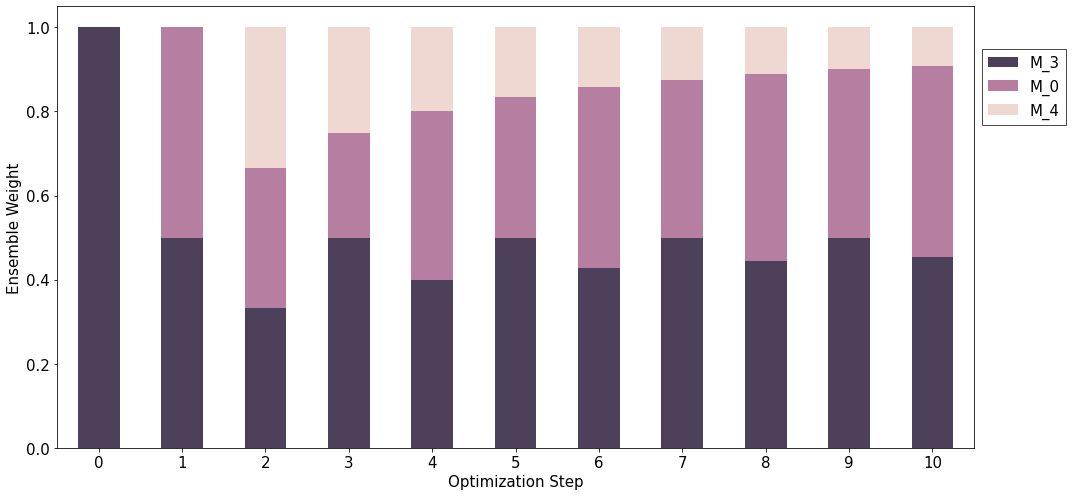

In [28]:

# Locate non-zero weights and sort models by their average weight
weights_to_plot = model_weights.loc[:, (model_weights != 0).any()]
weights_to_plot = weights_to_plot[
    weights_to_plot.mean().sort_values(ascending=False).index]

# A palette corresponding to the number of models with non-zero weights
palette = sns.cubehelix_palette(weights_to_plot.shape[1], reverse=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
weights_to_plot.plot(kind="bar", stacked=True, color=palette, ax=ax,
                     alpha=0.85)

ax.margins(x=0.0)
ax.set_xlabel("Optimization Step", fontsize=15, visible=True)
ax.set_ylabel("Ensemble Weight", fontsize=15, visible=True)
ax.yaxis.set_tick_params(rotation=0, labelsize=15)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)
ax.legend(loc="best", bbox_to_anchor=(1, 0.92),
          frameon=True, edgecolor="k", fancybox=False,
          framealpha=0.7, shadow=False, ncol=1, fontsize=15)
fig.tight_layout()